## Install the PGR-TK package

If neccessary, install the package into your python environment 
```
pip install --force /code/pgrtk-0.3.2-cp38-cp38-linux_x86_64.whl
```

In [1]:
import pgrtk
import os
import matplotlib.pyplot as plt
from IPython.display import SVG
%matplotlib inline

In [2]:
pgrtk.__version__

'pgrtk 0.3.2 (main:00d8eb3, release build, linux [x86_64] [rustc 1.62.0 (a8314ef7d 2022-06-27)])'

In [3]:
os.chdir("/results")

## Lazy load the the AGCfile for fetching sequences## Load the hg19 reference into `ref_seq`

In [4]:
ref_db =pgrtk.AGCFile("/data/pgr-tk-HGRP-y1-evaluation-set-v0.agc")

## Load the index into memory
The loads the index into the memory. It takes about one minute.

In [5]:
%%time
sdb = pgrtk.SeqIndexDB()
sdb.load_from_agc_index("/data/pgr-tk-HGRP-y1-evaluation-set-v0")


CPU times: user 20.2 s, sys: 2min 19s, total: 2min 39s
Wall time: 2min 3s


We can see the specification about how SHIMMERs are computed using the `get_shmmr_spec()` method. 

In [6]:
sdb.get_shmmr_spec() # window_size, k_mer_size, hieraical_reduction_factor, min_span, use_k_mer_sketch_other_than_minimizer

(80, 56, 4, 64, False)

## Query the database with the sequence of the region

We use a copy of the annotation for IGV hg19 to look up the chromosome and locations of the gene of interest.
We can fetch the region of interest with `ref_db`. Let's fetch the whole region and do a dot plot to examine the repeat structure. 

939


Text(0, 0.5, 'GRCh38, DAZ1/2/3/4 region')

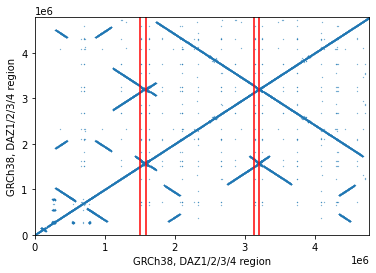

In [35]:
ref_file_name, roi_chr, roi_b, roi_e = \
('hg38_tagged.fa', 
'chrY_hg38', 
23129355, 
24907040)
#DAZ1_len = 23199094-23129355
#DAZ2_len = 23291356-23219434

padding = 1500000
DAZ1_s = 23129355-23129355 + padding
DAZ2_s = 23219434-23129355 + padding
DAZ3_s = 24763069-23129355 + padding
DAZ4_s = 24833919-23129355 + padding
roi_len = roi_e - roi_b
#get a segment of a reference
roi_seq = ref_db.get_sub_seq(ref_file_name, roi_chr, roi_b-padding, roi_e+padding)
x, y = pgrtk.get_shmmr_dots(roi_seq, roi_seq, 128, 56, 6, 32)
plt.plot(x, y, ".", markersize=0.5)
print(x[0])
plt.plot((DAZ1_s, DAZ1_s),(0,len(roi_seq)),'r-')
plt.plot((DAZ2_s, DAZ2_s),(0,len(roi_seq)),'r-')
plt.plot((DAZ3_s, DAZ3_s),(0,len(roi_seq)),'r-')
plt.plot((DAZ4_s, DAZ4_s),(0,len(roi_seq)),'r-')

plt.xlim(0,len(roi_seq))
plt.ylim(0,len(roi_seq))
plt.xlabel("GRCh38, DAZ1/2/3/4 region")
plt.ylabel("GRCh38, DAZ1/2/3/4 region")

In [8]:
#find hits in the pangenomic reference
aln_range = pgrtk.query_sdb(sdb, roi_seq, merge_range_tol=100000)

print("The number of hits is", len(aln_range))

count = 0
for sid, rgns in aln_range.items():
    count += len(rgns)

print("The total aligned regions is", count)

The number of hits is 190
The total aligned regions is 304


We can examine, the target region sizes.

In [9]:
rgn_lengths = []
for k in list(aln_range.keys()):
    b, e = aln_range[k][0][0:2]
    print(sdb.seq_info[k], "target region", b, "-", e, "len:", e-b )
    rgn_lengths.append(e-b)

('HG005#1#JAHEPO010000177.1', 'HG005.paternal.f1_assembly_v2_genbank.fa', 52042) target region 23793 - 24551 len: 758
('HG01243#1#JAHEOY010000035.1', 'HG01243.paternal.f1_assembly_v2_genbank.fa', 6702170) target region 3545396 - 3605603 len: 60207
('HG01928#1#JAGYVQ010000095.1', 'HG01928.paternal.f1_assembly_v2_genbank.fa', 6570700) target region 4315876 - 6570476 len: 2254600
('HG01109#1#JAHEPA010000162.1', 'HG01109.paternal.f1_assembly_v2_genbank.fa', 330255) target region 630 - 330181 len: 329551
('HG01243#1#JAHEOY010000156.1', 'HG01243.paternal.f1_assembly_v2_genbank.fa', 499785) target region 99322 - 116687 len: 17365
('HG02080#2#JAHEOV010000022.1', 'HG02080.maternal.f1_assembly_v2_genbank.fa', 42111193) target region 9594331 - 9596258 len: 1927
('HG01243#1#JAHEOY010000150.1', 'HG01243.paternal.f1_assembly_v2_genbank.fa', 2998306) target region 2211517 - 2998001 len: 786484
('HG02486#1#JAGYVM010000176.1', 'HG02486.paternal.f1_assembly_v2_genbank.fa', 513717) target region 380 - 21

Text(0, 0.5, 'count')

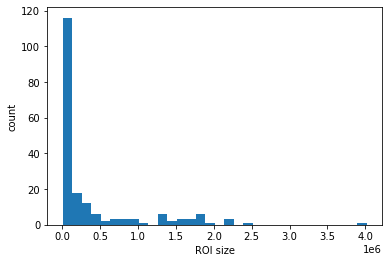

In [10]:
plt.hist(rgn_lengths, bins=32);
plt.xlabel("ROI size")
plt.ylabel("count")

Some mapped regions are larger, let's check the repeat / CNV by quick dot plots. We label the region of the ROI by two vertical grey lines. We observe that there are different number of intersections (~different copy number of the ROI) of the region the "dots" due to the different repeat structures.

HG01928.paternal.f1_assembly_v2_genbank.fa HG01928#1#JAGYVQ010000095.1
hg38_tagged.fa chrY_hg38
HG03579.paternal.f1_assembly_v2_genbank.fa HG03579#1#JAGYVU010000103.1
hg19_tagged.fa chrY_hg19
HG03492.paternal.f1_assembly_v2_genbank.fa HG03492#1#JAHEPI010000146.1
HG01106.paternal.f1_assembly_v2_genbank.fa HG01106#1#JAHAMC010000114.1
HG03492.paternal.f1_assembly_v2_genbank.fa HG03492#1#JAHEPI010000201.1
HG03098.paternal.f1_assembly_v2_genbank.fa HG03098#1#JAHEPM010000126.1
HG00673.paternal.f1_assembly_v2_genbank.fa HG00673#1#JAHBBZ010000163.1
HG005.paternal.f1_assembly_v2_genbank.fa HG005#1#JAHEPO010000082.1
HG02572.paternal.f1_assembly_v2_genbank.fa HG02572#1#JAHAOW010000284.1
HG005.paternal.f1_assembly_v2_genbank.fa HG005#1#JAHEPO010000046.1
HG00621.paternal.f1_assembly_v2_genbank.fa HG00621#1#JAHBCD010000079.1
HG02055.paternal.f1_assembly_v2_genbank.fa HG02055#1#JAHEPK010000089.1
chm13_tagged.fa chrY_chm13
HG00673.paternal.f1_assembly_v2_genbank.fa HG00673#1#JAHBBZ010000152.1
HG01109.

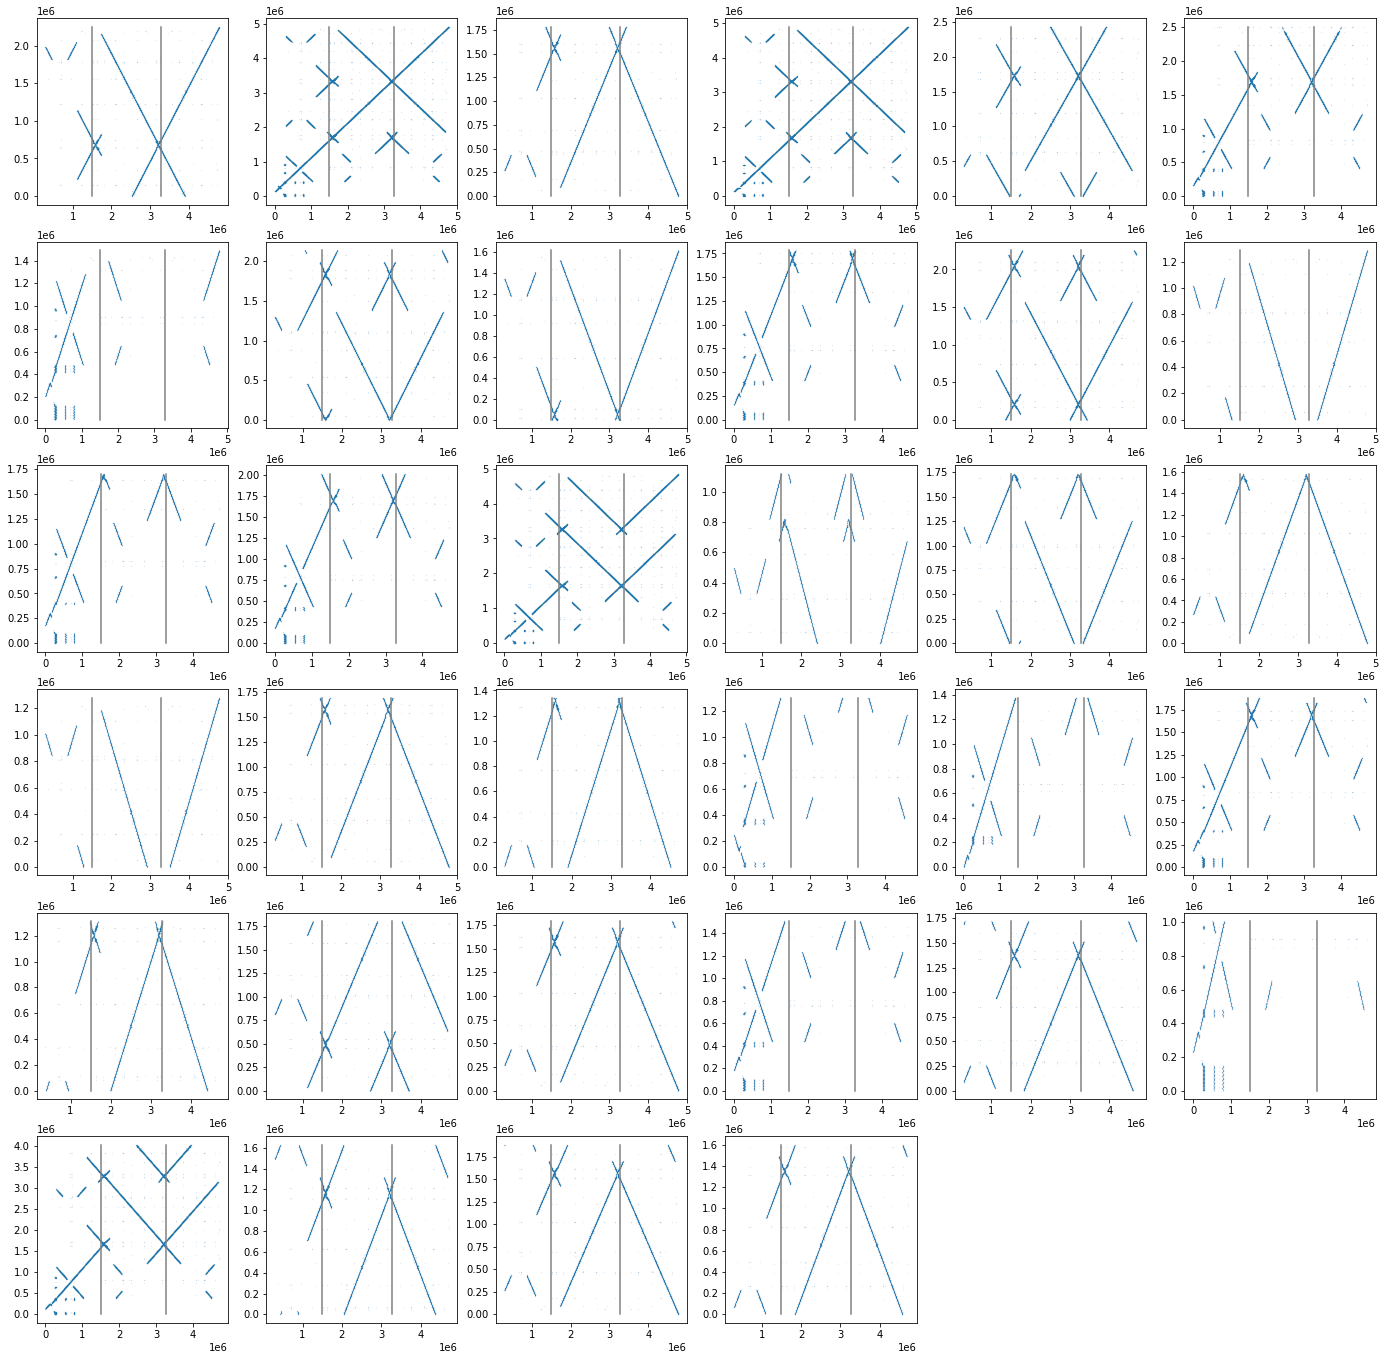

In [11]:
seq_list = []
i = 1
plt.figure(figsize=(24, 24))
for k in list(aln_range.keys()):
    ctg_name, source, _ = sdb.seq_info[k]
    seq_id = k
    rgns = aln_range[k].copy()

    rgns = pgrtk.merge_regions(rgns, tol=1000)

    for rgn in rgns:
        b, e, length, orientation, aln = rgn
        aln.sort()
  
        #if aln[0][0][0] > padding or aln[-1][0][1] < padding + roi_len:
        #    continue
        
        #for illustration purpose, we only plot with the sequnce spanned through the whole region

        #if e-b < 0.75 * (roi_len + 2 * padding):             
        #    continue
        if e-b < 1000000:
            continue
        print(source, ctg_name)

        seq =  sdb.get_sub_seq(source, ctg_name, b, e)
  
        if orientation == 1:
            seq = pgrtk.rc_byte_seq(seq)

        seq_list.append(("{}_{}_{}_{}".format(ctg_name, b, e, orientation), seq))
        x, y = pgrtk.get_shmmr_dots(roi_seq, seq, 128, 56, 6, 28)
        if len(x) == 0:
            continue
        
        if i <= 36:
            plt.subplot(6,6,i)
            plt.plot(x, y, ".", markersize=0.1)
            plt.plot([padding, padding],[0, max(y)], color='grey')
            plt.plot([padding+roi_len, padding+roi_len],[0, max(y)], color='grey')
        i += 1
        
        
        
        

## Create a new shimmer database for the detailed study

In [12]:
seq_list = []
seq_info = sdb.seq_info.copy()
i = 0
for k in list(aln_range.keys()):
    ctg_name, source, _ = seq_info[k]
    seq_id = k
    rgns = aln_range[k].copy()
    
    rgns = pgrtk.merge_regions(rgns,tol=1000)

    for rgn in rgns:
        b, e, length, orientation, aln = rgn
        
        #for illustration purpose, we only plot with the sequnce spanned through the whole region

        #if e-b < 0.75 * (roi_len + 2 * padding):             
        #    continue
        
        if e-b < 1000000:
            continue
            
        seq =  sdb.get_sub_seq(source, ctg_name, b, e)
        if orientation == 1:
            seq = pgrtk.rc_byte_seq(seq)
  
        seq_list.append(("{}_{}_{}_{}".format(ctg_name, b, e, orientation), seq))
        
        i += 1

sdb2 = pgrtk.SeqIndexDB()
sdb2.load_from_agc_index("/data/v2.7.XY.fasta")
aln_range2 = pgrtk.query_sdb(sdb2, roi_seq, merge_range_tol=100000)
seq_info = sdb2.seq_info.copy()
for k in list(aln_range2.keys()):
    ctg_name, source, _ = seq_info[k]
    seq_id = k
    rgns = aln_range2[k].copy()
    
    rgns = pgrtk.merge_regions(rgns,tol=1000)

    for rgn in rgns:
        b, e, length, orientation, aln = rgn
        
        #for illustration purpose, we only plot with the sequnce spanned through the whole region

        #if e-b < 0.75 * (roi_len + 2 * padding):             
        #    continue
        
        if e-b < 1000000:
            continue
            
        seq =  sdb2.get_sub_seq(source, ctg_name, b, e)
        if orientation == 1:
            seq = pgrtk.rc_byte_seq(seq)
  
        seq_list.append(("{}_{}_{}_{}".format(ctg_name, b, e, orientation), seq))
        
        i += 1

Create a shimmer indext database with smaller window (denser shimmers)

In [13]:
new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, w=80, k=56, r=6, min_span=18)

In [14]:
len(new_sdb.seq_info)

35

In [15]:
#find hits in the pangenomic reference
aln_range0 = pgrtk.query_sdb(new_sdb, roi_seq, merge_range_tol=300000)

aln_range = aln_range0

print("The number of hits is", len(aln_range))

count = 0
for sid, rgns in aln_range.items():
    count += len(rgns)

print("The total aligned regions is", count)

The number of hits is 35
The total aligned regions is 41


Let's loop through the hits (contigs that has alignments) and see the number of "copies".

In [16]:
from collections import Counter

In [17]:
n_copy = {}
for k in list(aln_range.keys()):
    n_copy[k] = len(aln_range[k])
copy_count = Counter(n_copy.values())
for nc, nh in copy_count.items():
    print("number of copy: {}, number of haplotypes: {}".format(nc, nh))

number of copy: 1, number of haplotypes: 30
number of copy: 3, number of haplotypes: 1
number of copy: 2, number of haplotypes: 4


Text(0, 0.5, 'count')

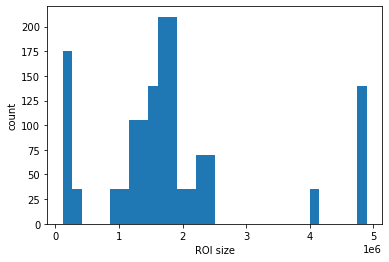

In [18]:
rgn_lengths = []
for k in list(aln_range.keys()):
    for sid, rgns in aln_range.items():
        for rgn in rgns:
            b, e = rgn[0:2]
            #print(seq_index[k], "target region", b, "-", e, "len:", e-b )
            rgn_lengths.append(e-b)
plt.hist(rgn_lengths, bins=32);
plt.xlabel("ROI size")
plt.ylabel("count")

In [19]:
f0 = open("/results/ROI_seq.fa", "w")
for ctg, seq in seq_list:
    
    print(">{}".format(ctg), file=f0)
    print(pgrtk.u8_to_string(seq), file=f0)
       
f0.close()

In [20]:
new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, w=80, k=56, r=6, min_span=18)
new_sdb.generate_mapg_gfa(0, "/results/ROI_80_56_6.gfa")

new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, w=80, k=56, r=2, min_span=18)
new_sdb.generate_mapg_gfa(0, "/results/ROI_80_56_2.gfa")

## Construct the genome graphs

In [21]:
import networkx as nx
from networkx.drawing import nx_pydot 

In [22]:
def get_graph(seq_list, w=128, k=56, r=4, min_span=28, highlite=0):
    new_sdb = pgrtk.SeqIndexDB() 
    new_sdb.load_from_seq_list(seq_list, w=w, k=k, r=r, min_span=min_span)
    new_sdb.generate_mapg_gfa(0, f"/results/{name}-{w}-{k}-{r}.gfa")
    sid_to_path = {}
    spl=new_sdb.get_shmmr_pair_list()
    for (k0, k1, sid, p0, p1, o) in spl:
        sid_to_path.setdefault(sid,[])
        sid_to_path[sid].append((p0, p1, o, k0, k1))
    G = nx.DiGraph()
    m = new_sdb.get_shmmr_map()
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        v = path[0]
        #if sid != 45:
        #    continue
        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "yellow"
            penwidth =  2 + 0.1 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_edge(v, w, penwidth = penwidth, color="orange" )
            G.add_edge(w, v, penwidth = penwidth, color="orange" )
            G.add_node(v, fillcolor=color, style="filled")
            #G.add_node(w, size =  len(m[v]))
            v = w
            
    node_to_sid = {}
    for v in G.nodes():
        node_to_sid.setdefault(v, {})
        for sid, path in sid_to_path.items():
            node_to_sid[v][sid] = 0
            
     
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        for v in path:
            v = tuple(v[-2:])
            node_to_sid[v][sid] = 1
    #nx.set_node_attributes(G, node_to_sid)  
    return G
    

In [23]:
def get_graph2(seq_list, w=128, k=56, r=4, min_span=28, highlite=0):
    new_sdb = pgrtk.SeqIndexDB() 
    new_sdb.load_from_seq_list(seq_list, w=w, k=k, r=r, min_span=min_span)
    new_sdb.generate_mapg_gfa(0, f"/results/{name}-{w}-{k}-{r}.gfa")
    sid_to_path = {}
    spl=new_sdb.get_shmmr_pair_list()
    for (k0, k1, sid, p0, p1, o) in spl:
        sid_to_path.setdefault(sid,[])
        sid_to_path[sid].append((p0, p1, o, k0, k1))
    G = nx.DiGraph()
    m = new_sdb.get_shmmr_map()
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        v = path[0]
        #if sid != 45:
        #    continue
        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "yellow"
            penwidth =  1 + 0.02 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_edge(v, w, penwidth = penwidth, color="orange" )
            G.add_edge(w, v, penwidth = penwidth, color="orange" )
            G.add_node(v, fillcolor=color, style="filled")
            #G.add_node(w, size =  len(m[v]))
            v = w
            
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        v = path[0]
        if sid != highlite:
            continue
        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "blue"
            penwidth =  1 + 0.02 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_node(v, fillcolor=color, style="filled")
            G.add_edge(v, w, penwidth = penwidth, color=color )
            G.add_edge(w, v, penwidth = penwidth, color=color )
            v = w
    return G
    

## Generate Repeat Pattern Using the Principal Bundles

In [24]:
shmmrspec = {"w": 128, "k":56, "r":6, "min_span":28 }
new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, 
                           w = shmmrspec["w"], 
                           k = shmmrspec["k"], 
                           r = shmmrspec["r"], 
                           min_span = shmmrspec["min_span"])

In [25]:
principal_bundles, sid_smps = new_sdb.get_principal_bundle_decomposition(0,8)
sid_smps = dict(sid_smps)
print(len(principal_bundles))

68


In [26]:
import numpy as np
from matplotlib import cm

In [27]:
cmap=plt.get_cmap("nipy_spectral")
cmap

In [28]:
lpb = len(principal_bundles)
color_theme0 = cmap(np.linspace(0.1, 0.9, lpb))
#pseudo-randomize the colors
idx = np.array([_ * (lpb+8011) for _ in range(lpb)]) % lpb
print(idx)
color_theme = color_theme0[idx]

[ 0 55 42 29 16  3 58 45 32 19  6 61 48 35 22  9 64 51 38 25 12 67 54 41
 28 15  2 57 44 31 18  5 60 47 34 21  8 63 50 37 24 11 66 53 40 27 14  1
 56 43 30 17  4 59 46 33 20  7 62 49 36 23 10 65 52 39 26 13]


In [29]:
new_sdb.generate_mapg_gfa(0, "/results/test_48_56_4_28.gfa")

v_to_name = {}
with open("/results/test_48_56_4_28.gfa") as f:
    for r in f:
        r = r.strip().split("\t")
        if r[0] != "S":
            continue
        n = r[1]
        v = r[4].split(":")[-1]
        v_to_name[v] = n

f = open("/results/test_48_56_4_28_color.csv", "w")
print("Name,Color", file=f)
for bundle_id, bundle in enumerate(principal_bundles):
    for v in bundle[2]:
        vertex = tuple(v[:2])
        color = color_theme[bundle_id]
  
        print(v_to_name["{:016x}_{:016x}".format(*vertex)], color, file=f, sep=",")
f.close()

In [30]:
b_vertex_to_position = {}
i = 0
for bundle in principal_bundles:
    for v in bundle[2]:
        vertex = tuple(v[:2])
        b_vertex_to_position[vertex] = i, bundle[0]
        i += 1

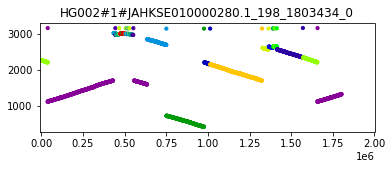

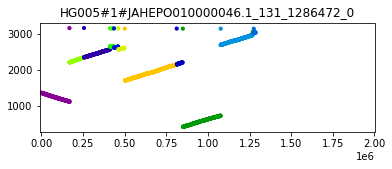

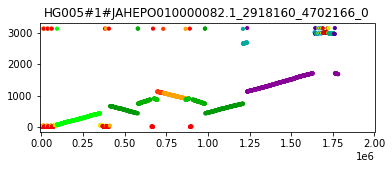

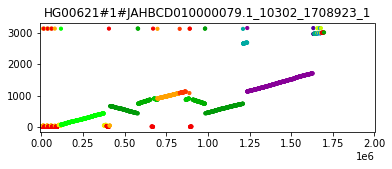

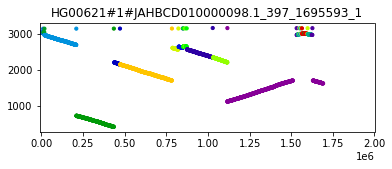

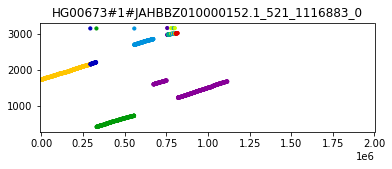

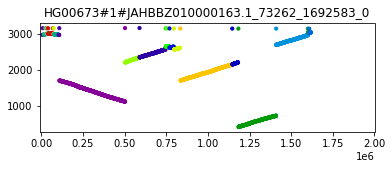

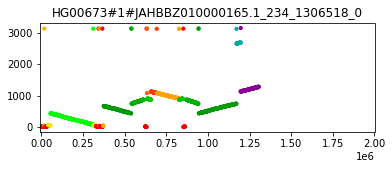

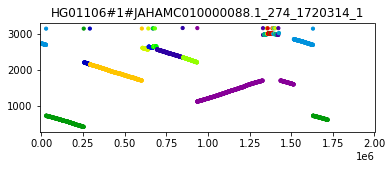

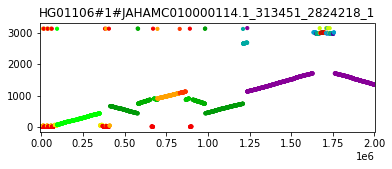

In [31]:
seq_info = new_sdb.seq_info.copy()
sinfo = list(seq_info.items())
sinfo.sort(key=lambda x: x[1][0])

#fig = plt.figure(figsize=(24,96))
pidx = 1
for sid, data in sinfo[:10]:
    ctg, _, _ = data
    smps = sid_smps[sid]
    #print(seq_info[sid])
    #print(sid, len(smps))
    x, rx = [], []
    y, ry = [], []
    c, rc = [], []

   
    for s in smps:
        if s[1] is None:
            continue
        vertex = tuple(s[0][:2])
        x.append(s[0][2])
        y.append(b_vertex_to_position[vertex][0]) # same direction
        c.append(color_theme[s[1][0]])
            

    fig = plt.figure(figsize=(6,2))
    plt.scatter(x, y, marker=".", color=c, s=40)
    
    
    plt.xlim(-10000,2000000)
    plt.title(ctg)
    

In [32]:
ref_file_name, daz1_chr, daz1_b, daz1_e = \
('hg38_tagged.fa', 
'chrY_hg38', 23129355, 
23199094)
DAZ1_len = 23199094-23129355
DAZ2_len = 23291356-23219434
padding = 100
#roi_len = roi_e - roi_b
#get a segment of a reference
DAZ1_seq = ref_db.get_sub_seq(ref_file_name, daz1_chr, daz1_b-padding, daz1_e+padding)

ref_file_name, daz2_chr, daz2_b, daz2_e = \
('hg38_tagged.fa', 
'chrY_hg38', 23219434, 
23291356)
DAZ1_len = 23199094-23129355
DAZ2_len = 23291356-23291356
padding = 100
#roi_len = roi_e - roi_b
#get a segment of a reference
DAZ2_seq = ref_db.get_sub_seq(ref_file_name, daz2_chr, daz2_b-padding, daz2_e+padding)

ref_file_name, daz3_chr, daz3_b, daz3_e = \
('hg38_tagged.fa', 
'chrY_hg38', 24763069, 
24813492)

padding = 100
#roi_len = roi_e - roi_b
#get a segment of a reference
DAZ3_seq = ref_db.get_sub_seq(ref_file_name, daz3_chr, daz3_b-padding, daz3_e+padding)


ref_file_name, daz4_chr, daz4_b, daz4_e = \
('hg38_tagged.fa', 
'chrY_hg38', 24833919, 
24907040)

padding = 100
#roi_len = roi_e - roi_b
#get a segment of a reference
DAZ4_seq = ref_db.get_sub_seq(ref_file_name, daz4_chr, daz4_b-padding, daz4_e+padding)



In [33]:
gene_matches1 = new_sdb.get_match_positions_with_fragment(DAZ1_seq)
gene_matches2 = new_sdb.get_match_positions_with_fragment(DAZ2_seq)
gene_matches3 = new_sdb.get_match_positions_with_fragment(DAZ3_seq)
gene_matches4 = new_sdb.get_match_positions_with_fragment(DAZ4_seq)
gene_matches = [gene_matches1, gene_matches2, gene_matches3, gene_matches4]

<ipython-input-36-0b09d1b28393>:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(24,3))


<Figure size 1728x4608 with 0 Axes>

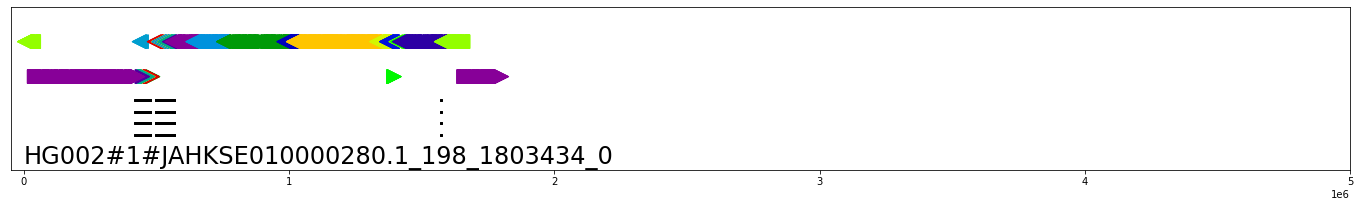

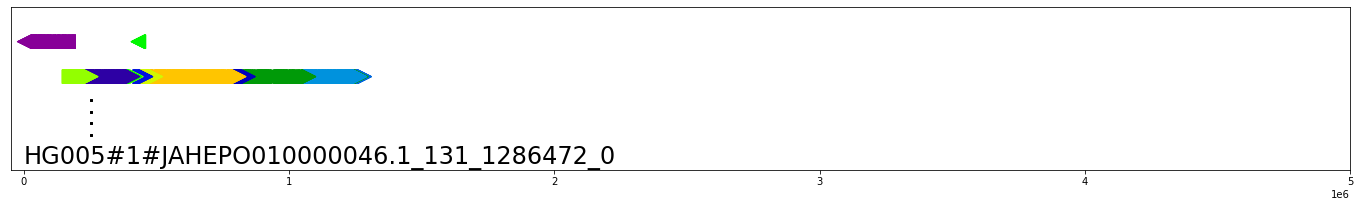

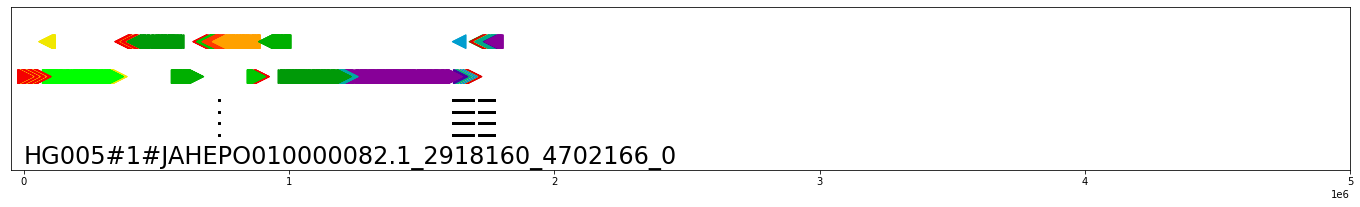

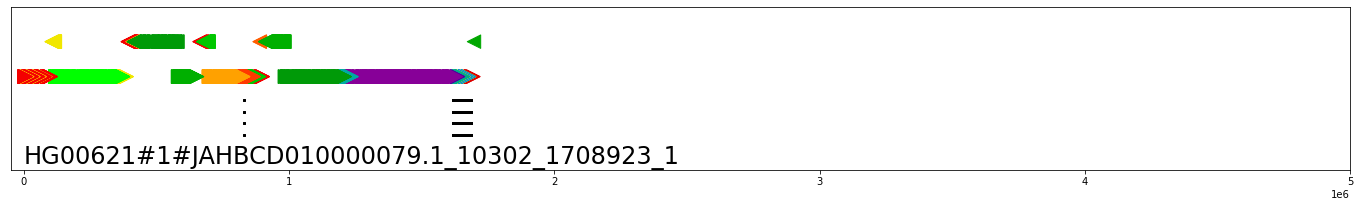

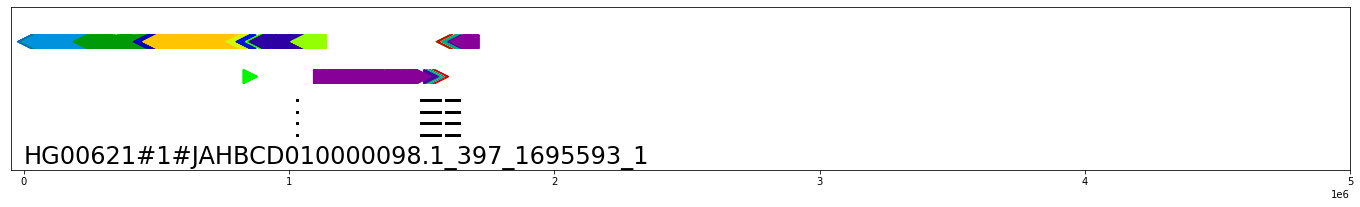

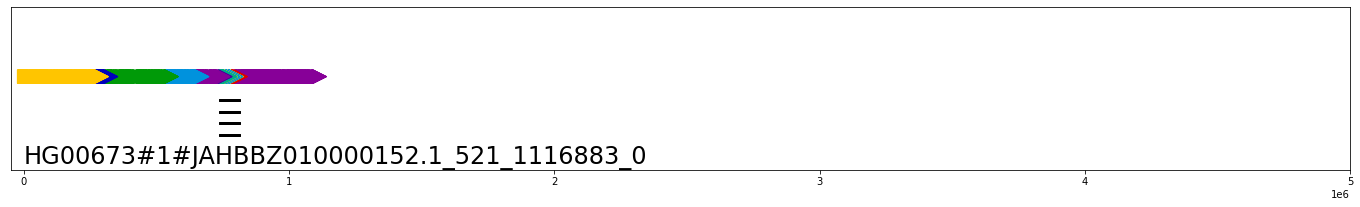

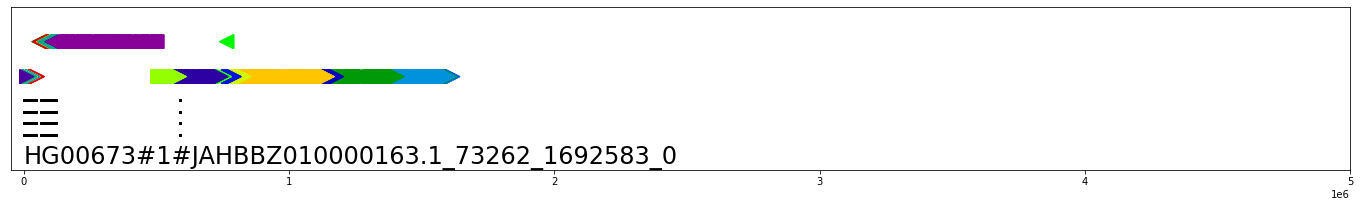

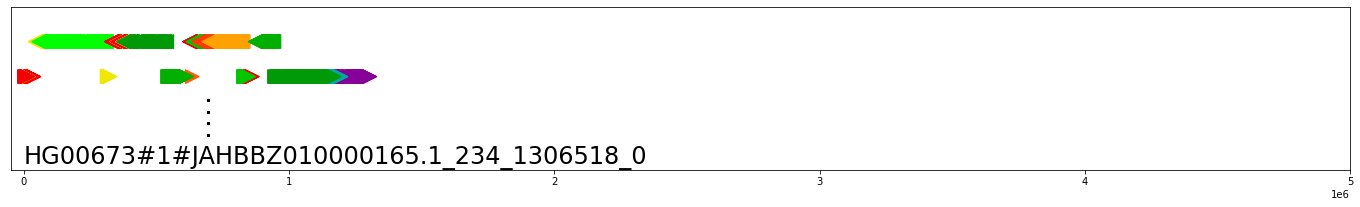

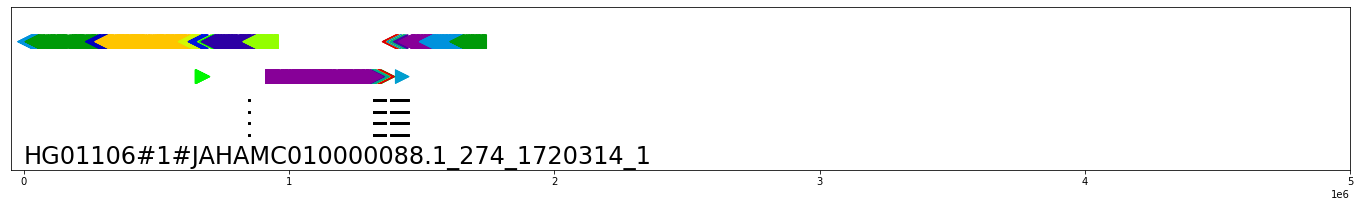

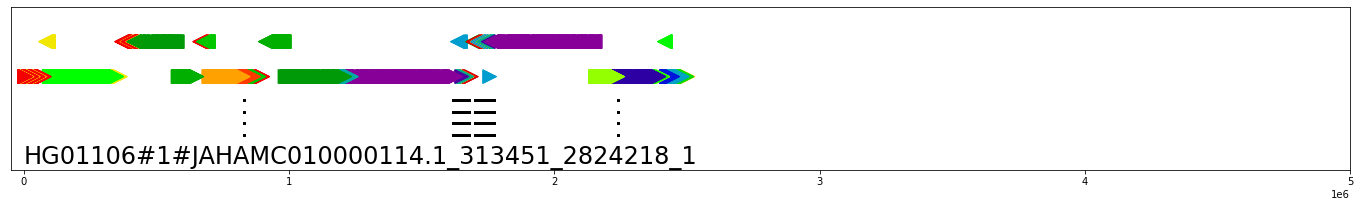

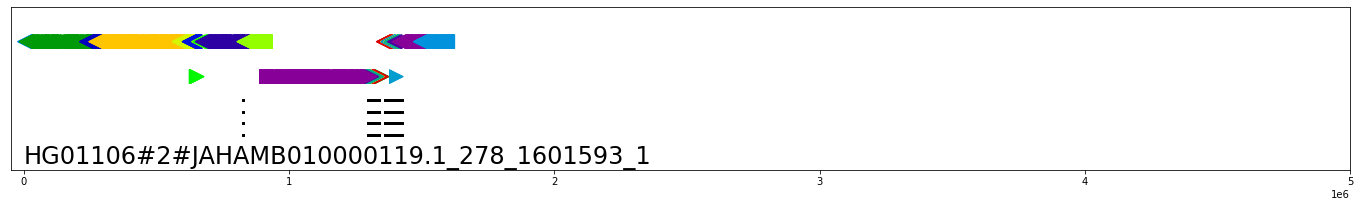

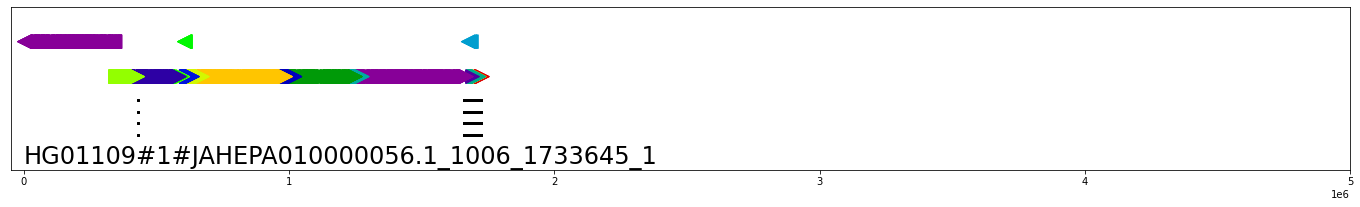

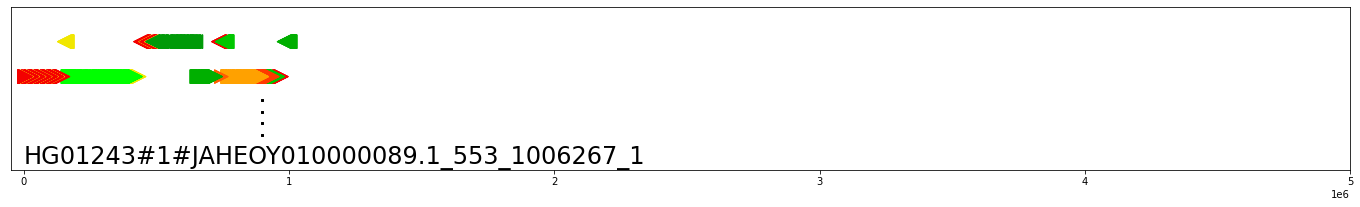

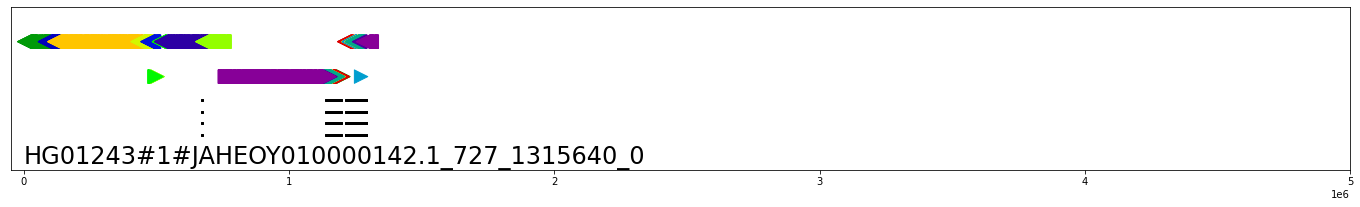

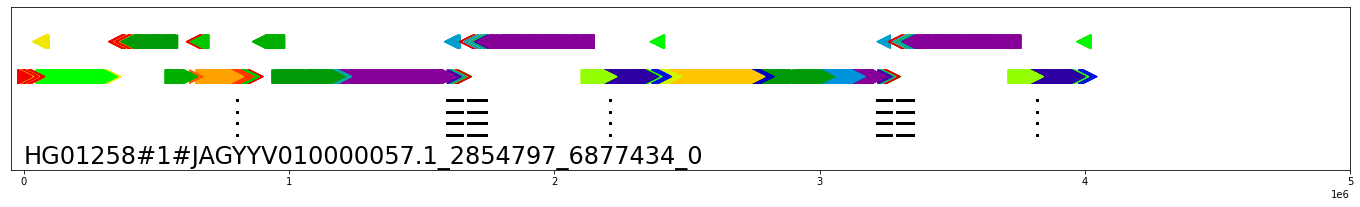

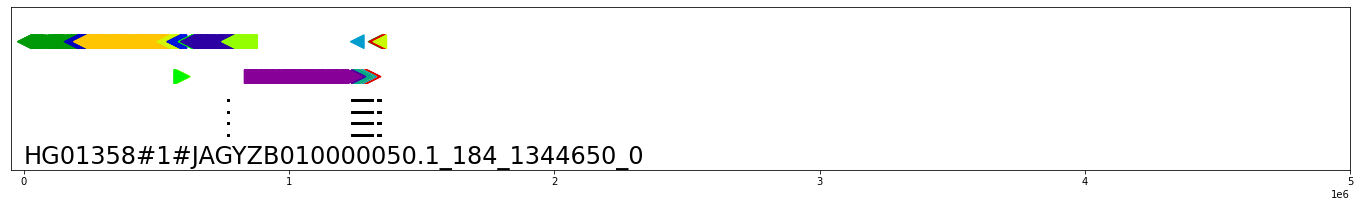

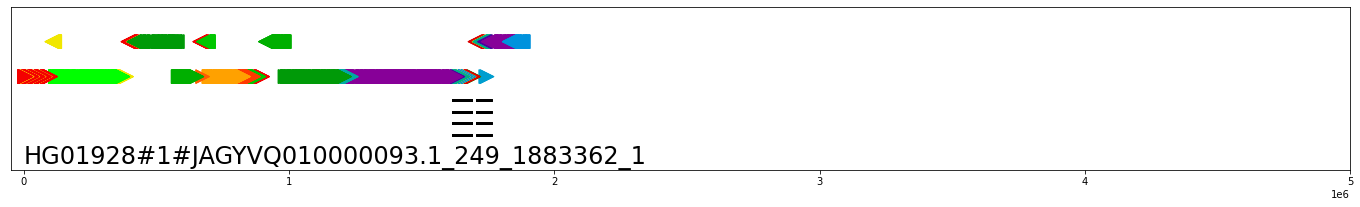

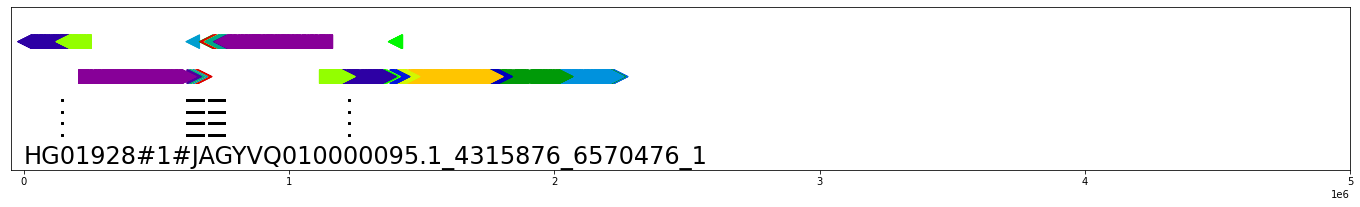

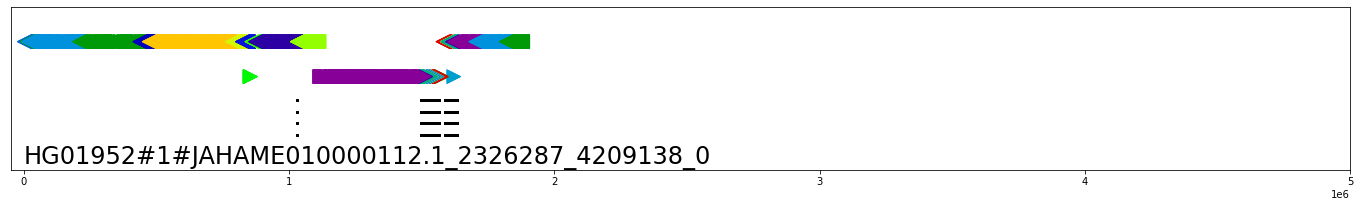

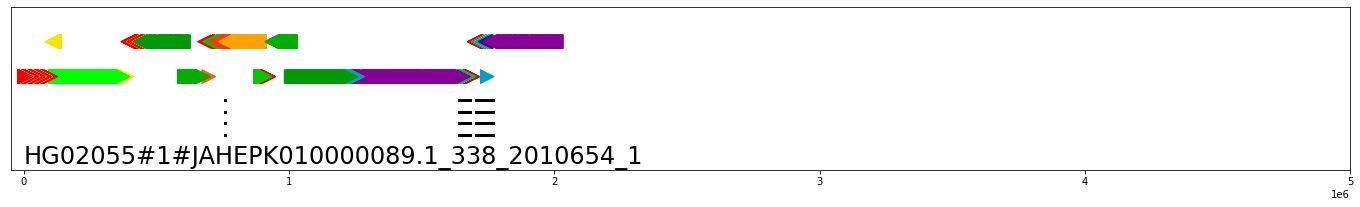

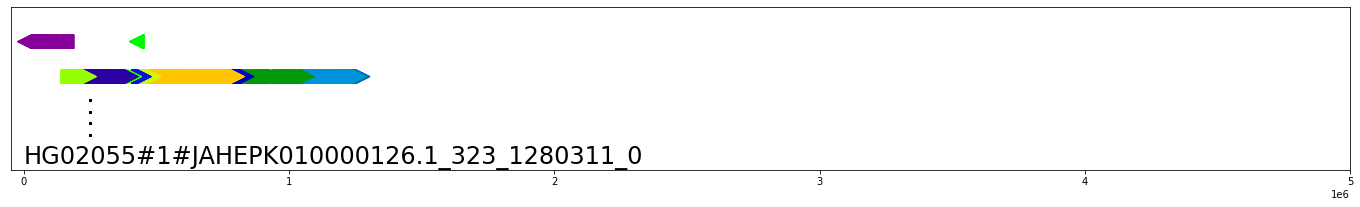

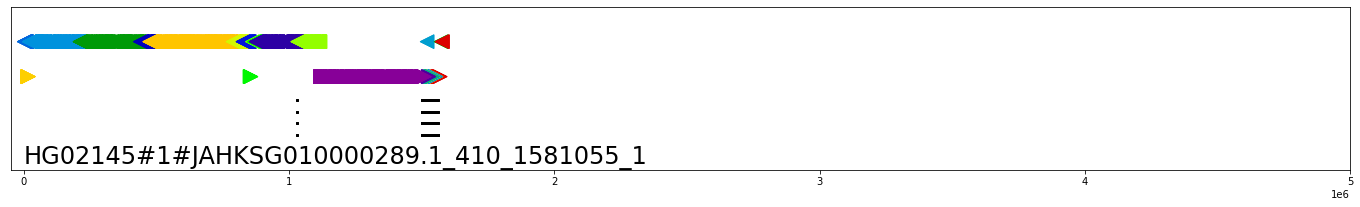

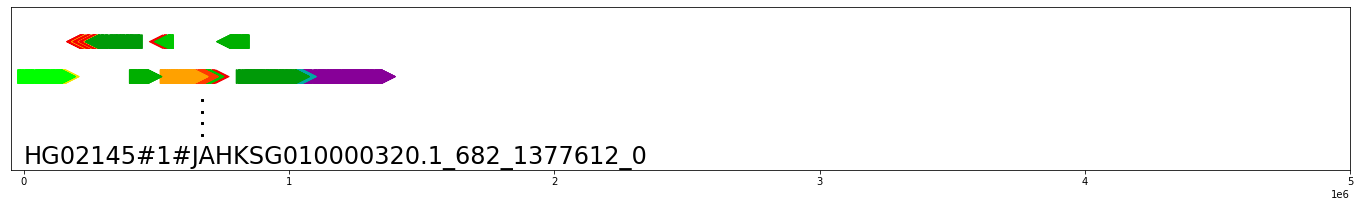

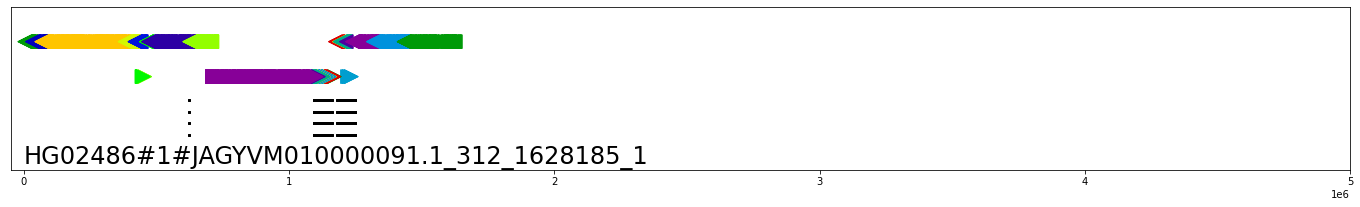

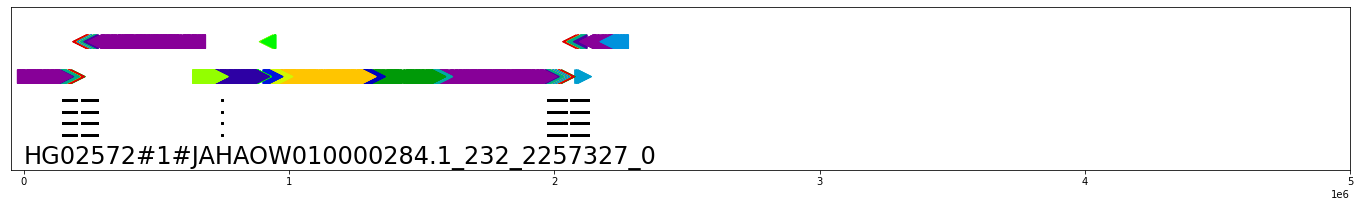

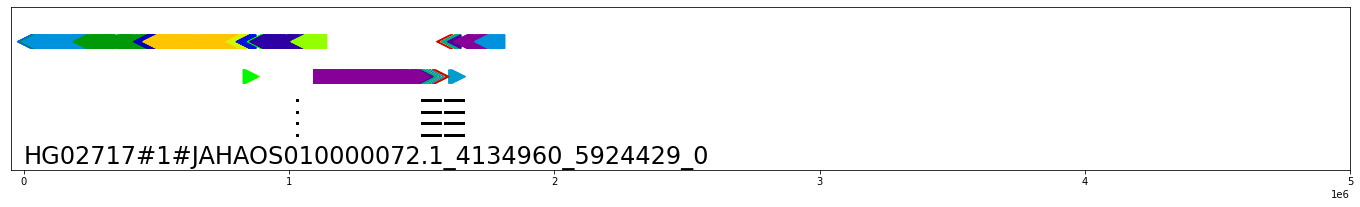

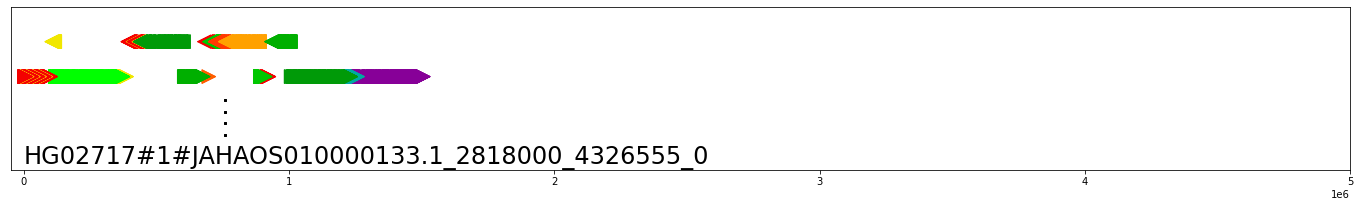

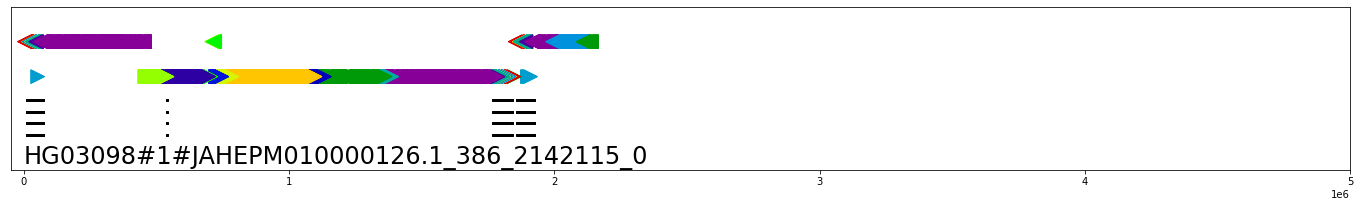

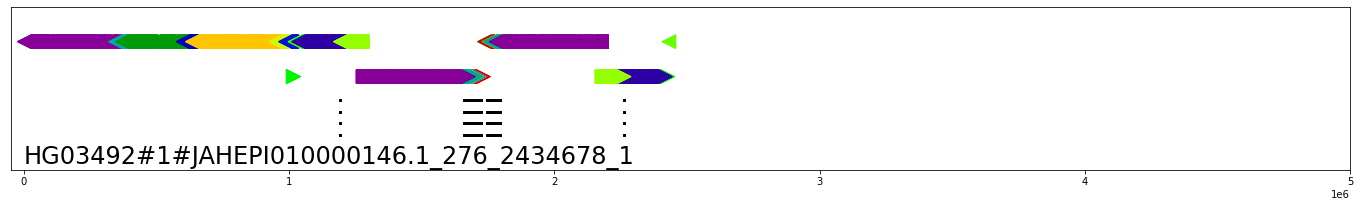

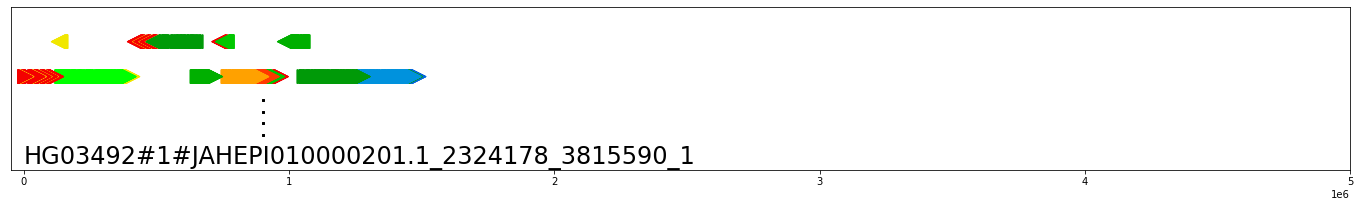

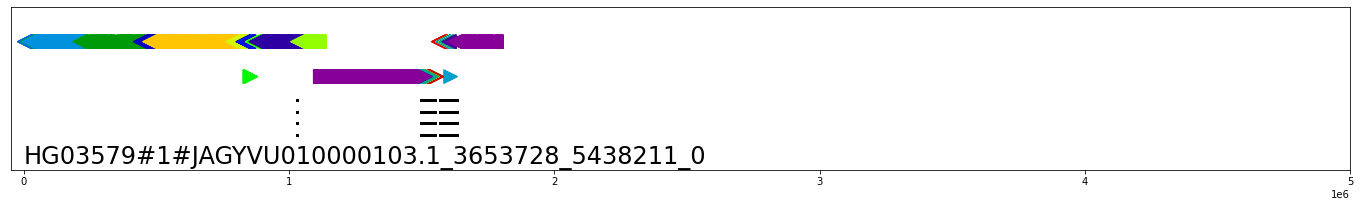

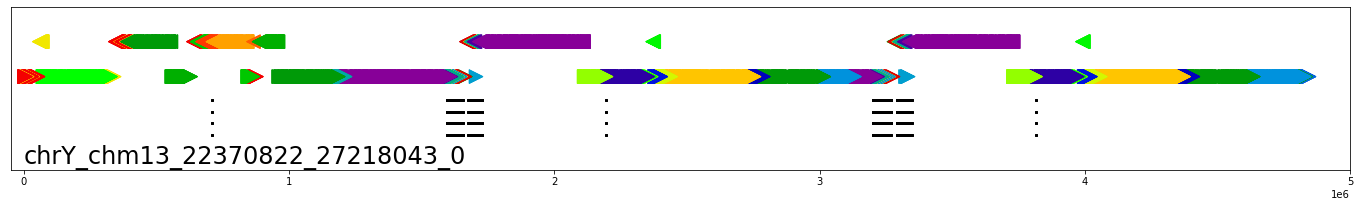

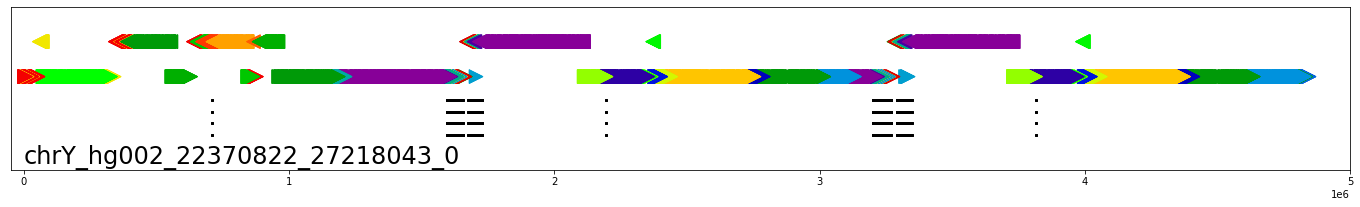

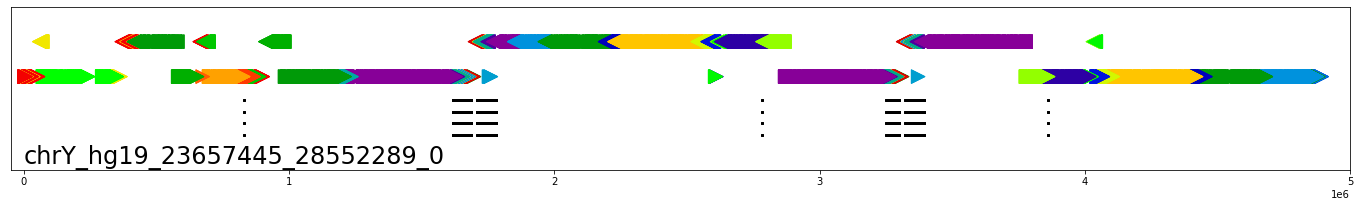

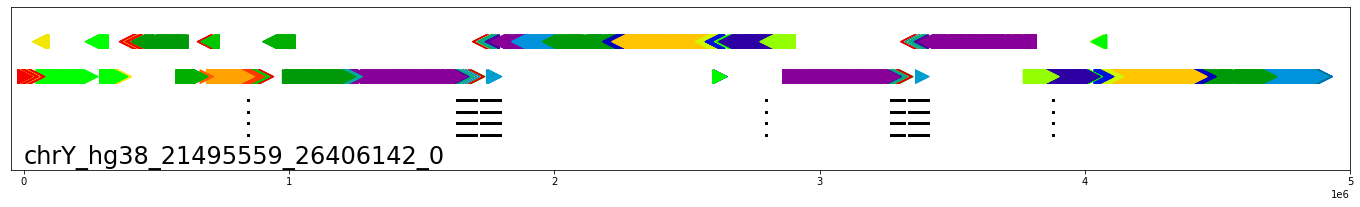

In [36]:
seq_info = new_sdb.seq_info.copy()
sinfo = list(seq_info.items())
sinfo.sort(key=lambda x: x[1][0])

fig = plt.figure(figsize=(24,64))
# pidx = 1
for sid, data in sinfo:
    ctg, _, _ = data
    smps = sid_smps[sid]
    #print(seq_info[sid])
    #print(sid, len(smps))
    x, rx = [], []
    y, ry = [], []
    c, rc = [], []
    for s in smps:
        if s[1] is None:
            continue
        
        if s[0][4] == s[1][1]:
            x.append(s[0][2])
            y.append(0) # same direction
            c.append(color_theme[s[1][0]])
        else:
            rx.append(s[0][2])
            ry.append(6)
            rc.append(color_theme[s[1][0]])
   
            
    y = np.array(y) 
    ry = np.array(ry)
    x.reverse()
    c.reverse()
    
    # plt.subplot(len(sid_smps), 1, pidx)
    # pidx += 1
    
    plt.figure(figsize=(24,3))
    plt.scatter(x, y, marker=">", color=c, s=180)
    plt.scatter(rx, ry, marker="<", color=rc, s=180)
    
    
    for mi in range(4):
        matches = set([(_[0], _[1]) for _ in gene_matches[mi][sid]])
        track_x = [_[0] for _ in matches]
        plt.scatter(track_x, [-4-mi*2]*len(track_x), marker="s", color="black", s=2)
  
    
    
    #track0_x = [_[0] for _ in gene_matches[sid]]
    #plt.scatter(track0_x, [-6]*len(track0_x), marker="s", color="black", s=20)
    
    #plt.axis("off")
    plt.yticks([])
    plt.ylim(-16,12)
    plt.xlim(-50000,5000000)
    plt.text(0, -15, ctg, fontsize=24)